In [1]:
using PyPlot

/Users/kolbylyn/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [3]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];

In [4]:
per1 = mean(t1[2:end]-t1[1:end-1])
per2 = mean(t2[2:end]-t2[1:end-1]);

In [5]:
println(per1,'\n',per2)
# 5. venus and earth!

224.70076641863517
365.25630708152175


In [6]:
x1 = collect(0:1:length(t1)-1)
x2 = collect(0:1:length(t2)-1);

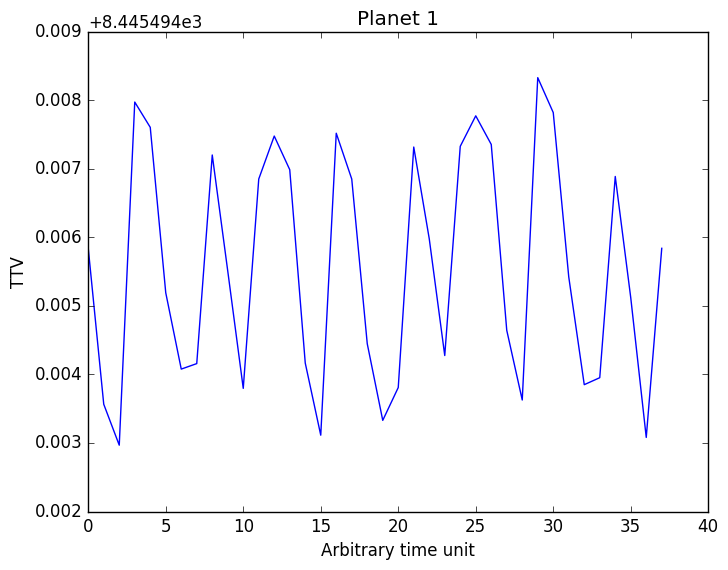

In [7]:
plot(x1,t1-(x1*per1))
xlabel("Arbitrary time unit")
ylabel("TTV")
title("Planet 1");

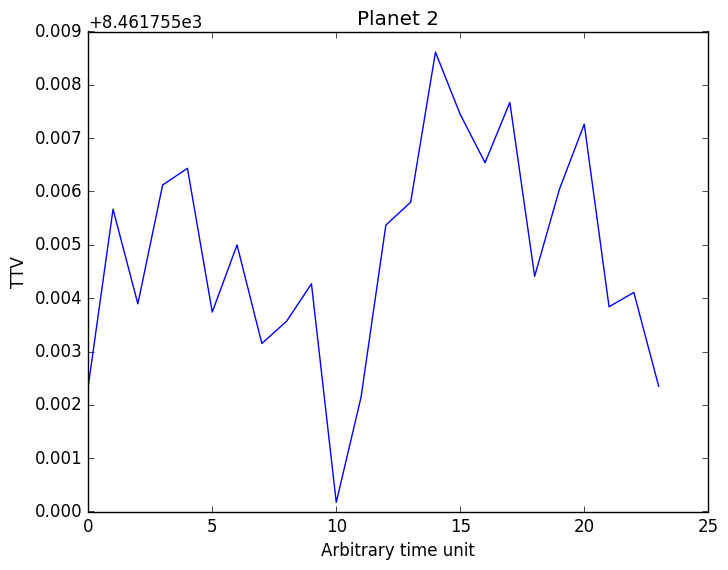

In [8]:
plot(x2,t2-(x2*per2))
xlabel("Arbitrary time unit")
ylabel("TTV")
title("Planet 2");

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [9]:
function make_plane(mass_ratio::Float64,period::Float64,t0::Float64,ecosw::Float64,esinw::Float64)
    plane = Planet_plane_hk(mass_ratio, period, t0, ecosw, esinw)
    return plane
end

make_plane (generic function with 1 method)

In [60]:
function compute_ttv_pairs(jmax::Int64,n_p::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64}},times::Array{Array{Float64}})
    ttvs = [zeros(length(time)) for time in times] 
    for i=1:n_p-1 #for each planet
        for j=i:n_p #go to each other planet
            if i!= j #make sure its not this planet
                compute_ttv!(jmax,planets[i],planets[j],times[i],times[j],ttvs[i],ttvs[j]) #compute ttvs, add to array
            end
        end
    end
    return ttvs
end

compute_ttv_pairs (generic function with 2 methods)

In [59]:
plane1 = make_plane(.01,per1,1.,0.1,0.1)
plane2 = make_plane(.01,per2,1.,0.1,0.1)

TTVFaster.Planet_plane_hk{Float64}(0.01,365.25630708152175,1.0,0.1,0.1)

In [66]:
times = Array{Float64}[t1,t2]
planes = [plane1,plane2]
ttvs = compute_ttv_pairs(10,2,planes,times)

2-element Array{Array{Float64,1},1}:
 [-10.3124,-11.4414,12.0241,12.1178,-0.590251,-13.028,-12.7528,12.5832,11.6741,4.44406  …  11.2881,11.3537,-1.40554,-13.6563,-13.3667,13.3413,12.6263,4.89829,-1.4216,-1.64513]
 [1.7563,-6.89469,-4.08171,-1.24742,4.35016,7.21672,-3.36915,2.33725,2.12196,-7.15928  …  -3.06952,2.69973,2.49521,-7.39529,-4.41208,-1.46142,3.88163,6.69577,-2.77909,3.04888]

### 2. Carry out an initial fit to the transit times of the two planets.

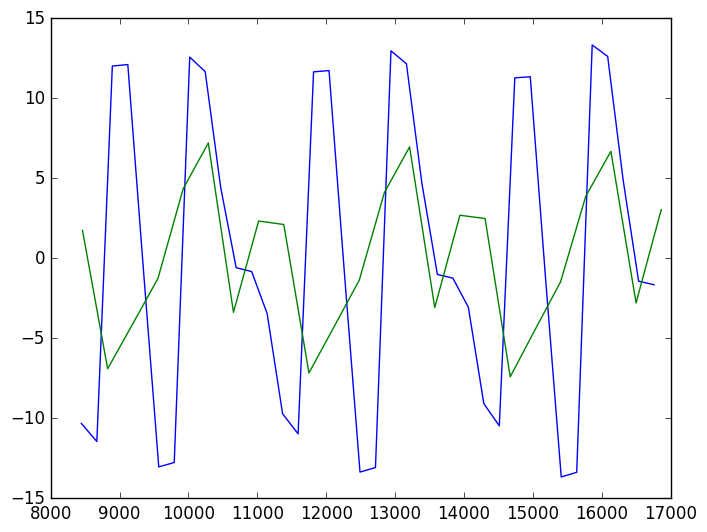

In [67]:
plot(t1,ttvs[1])
plot(t2,ttvs[2]);

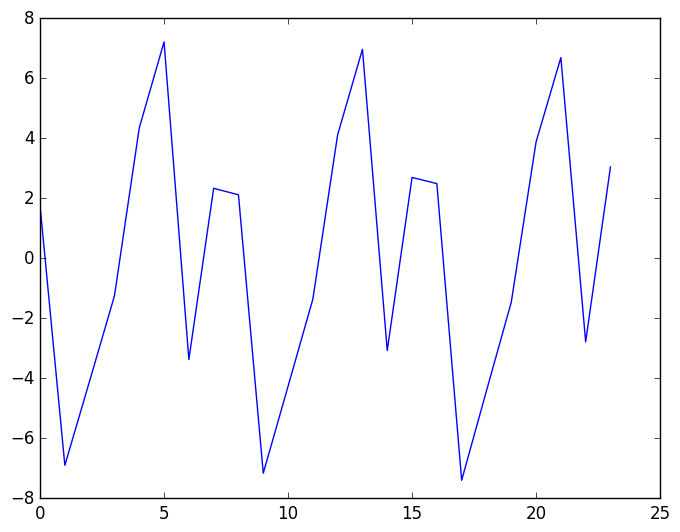

In [68]:
plot(ttvs[2]);

### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

to find third planet:
calculate residuals from O-C. so subtract TTVs from model then redo compute_ttv to find third nontransiting planet. 

